In [1]:
import pandas as pd
import sqlite3 as sql
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime
from jupyterthemes import jtplot
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

%matplotlib inline
jtplot.style()

In [2]:
#!pip install openpyxl

In [3]:
police_calls = pd.read_excel('../data/police_calls.xlsx')

In [4]:
#police_calls.head()

In [5]:
police_calls = police_calls.dropna()

In [6]:
#police_calls.info()

In [7]:
police_calls["Precinct"].value_counts()

H       7957
S       7953
C       6870
MT      5973
N       5515
M       4867
E       4408
W       4258
CW       118
PCW        4
CMD1       2
CMD2       1
Name: Precinct, dtype: int64

In [8]:
police_calls['Incident Type'].value_counts()

DISORDERLY SUBJECT      15568
ASSIST EMS              10043
WELFARE CHECK            9545
TRESPASSER               4023
SUSPICIOUS PERSON        2797
DOMESTIC DISTURBANCE     2661
SUICIDAL PERSON          1725
MENTAL CONDITION         1266
INTOXICATED PERSON        298
Name: Incident Type, dtype: int64

In [9]:
conn = sql.connect('../data/census.sqlite')
cur = conn.cursor()

In [10]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")

In [11]:
available_tables = (cur.fetchall())
print(available_tables)

[('B01001',), ('B03002',), ('B11001',), ('B11002',), ('B15002',), ('B19001',), ('B19013',), ('B19301',), ('B25024',), ('B25075',), ('S1701',)]


In [12]:
age_sex = pd.read_sql("SELECT * FROM B01001;", conn)

In [13]:
#age_sex.head()

In [14]:
race = pd.read_sql("SELECT * FROM B03002;", conn)

In [15]:
household_type = pd.read_sql("SELECT * FROM B11001;", conn)
pop_household = pd.read_sql("SELECT * FROM B11002;", conn)
education = pd.read_sql("SELECT * FROM B15002;", conn)
income = pd.read_sql("SELECT * FROM B19001;", conn)
housing_value = pd.read_sql("SELECT * FROM B25075;", conn)
poverty_status = pd.read_sql("SELECT * FROM S1701;", conn)

In [16]:
#income.head(2)

In [17]:
census = ['age_sex', 'race', 'household_type','pop_household','education','income','housing_value']

In [18]:
## for loops to remove 'Estimate!!Total:!!' from census list
##for i in census:
##    for d in description

In [19]:
active_in_care = police_calls.loc[(police_calls.Precinct == 'H') | (police_calls.Precinct == 'N')]
active_in_care.head(2)

,Precinct,Date,Created,Address,Incident Type,Priority
1264,H,07-01-2021,00:54:10,2827 SMITH SPRINGS RD,DISORDERLY SUBJECT,2
1265,H,07-01-2021,01:58:23,1000 THOMPSON PL,SUSPICIOUS PERSON,2


In [20]:
#police_calls.loc[(police_calls.Precinct != 'H') & (police_calls.Precinct != 'N')]

In [21]:
geocodes = pd.read_csv('../data/geocodes.csv')

In [22]:
police_calls = pd.merge(police_calls, geocodes, 
         left_on = 'Address', right_on = 'address', 
                               how = 'left')

In [23]:
precinct_options = police_calls.loc[(police_calls.Precinct != 'H') & (police_calls.Precinct != 'N')]

<AxesSubplot:>

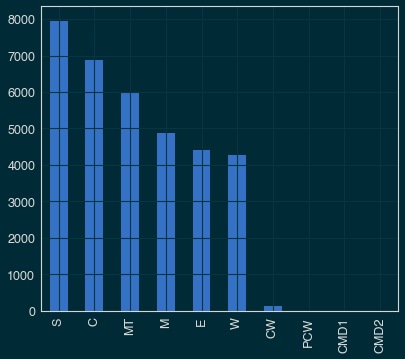

In [24]:
precinct_options.Precinct.value_counts().plot(kind='bar')

In [25]:
## reduce precint options to eliminate low-call regions
precinct_options = precinct_options.loc[(precinct_options.Precinct != 'CW') &
                                        (precinct_options.Precinct != 'PCW')&
                                        (precinct_options.Precinct != 'CMD1') &
                                        (precinct_options.Precinct != 'CMD2')]

<AxesSubplot:>

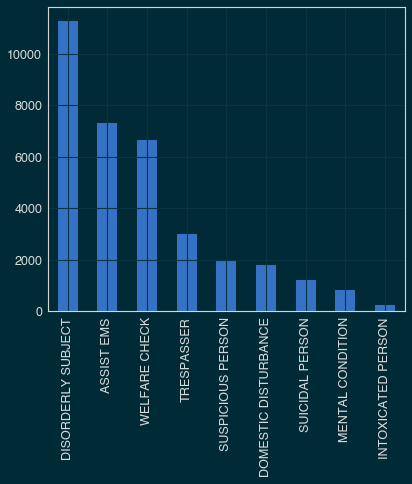

In [26]:
precinct_options['Incident Type'].value_counts().plot(kind='bar')

In [27]:
facet_test = pd.DataFrame(precinct_options.groupby(['Precinct','Incident Type']).size().unstack())

In [28]:
facet_test.head(2)

Incident Type,ASSIST EMS,DISORDERLY SUBJECT,DOMESTIC DISTURBANCE,INTOXICATED PERSON,MENTAL CONDITION,SUICIDAL PERSON,SUSPICIOUS PERSON,TRESPASSER,WELFARE CHECK
Precinct,,,,,,,,,
C,1510,2734,99,73,171,349,171,1023,740
E,887,1457,324,29,110,131,290,291,889


In [29]:
#g = sns.FacetGrid(data = facet_test,
#                 col = 'Precinct',
#                 hue = 'Precinct')
#g.map(sns.barplot, 'Incident Type')

In [30]:
precinct_options.groupby(['Precinct','Incident Type']).size().unstack(fill_value=0)

Incident Type,ASSIST EMS,DISORDERLY SUBJECT,DOMESTIC DISTURBANCE,INTOXICATED PERSON,MENTAL CONDITION,SUICIDAL PERSON,SUSPICIOUS PERSON,TRESPASSER,WELFARE CHECK
Precinct,,,,,,,,,
C,1510,2734,99,73,171,349,171,1023,740
E,887,1457,324,29,110,131,290,291,889
M,1119,1368,366,15,116,184,295,288,1116
MT,1250,1938,259,53,141,179,417,557,1179
S,1650,2548,559,44,190,237,417,553,1755
W,903,1218,179,28,113,141,370,310,996


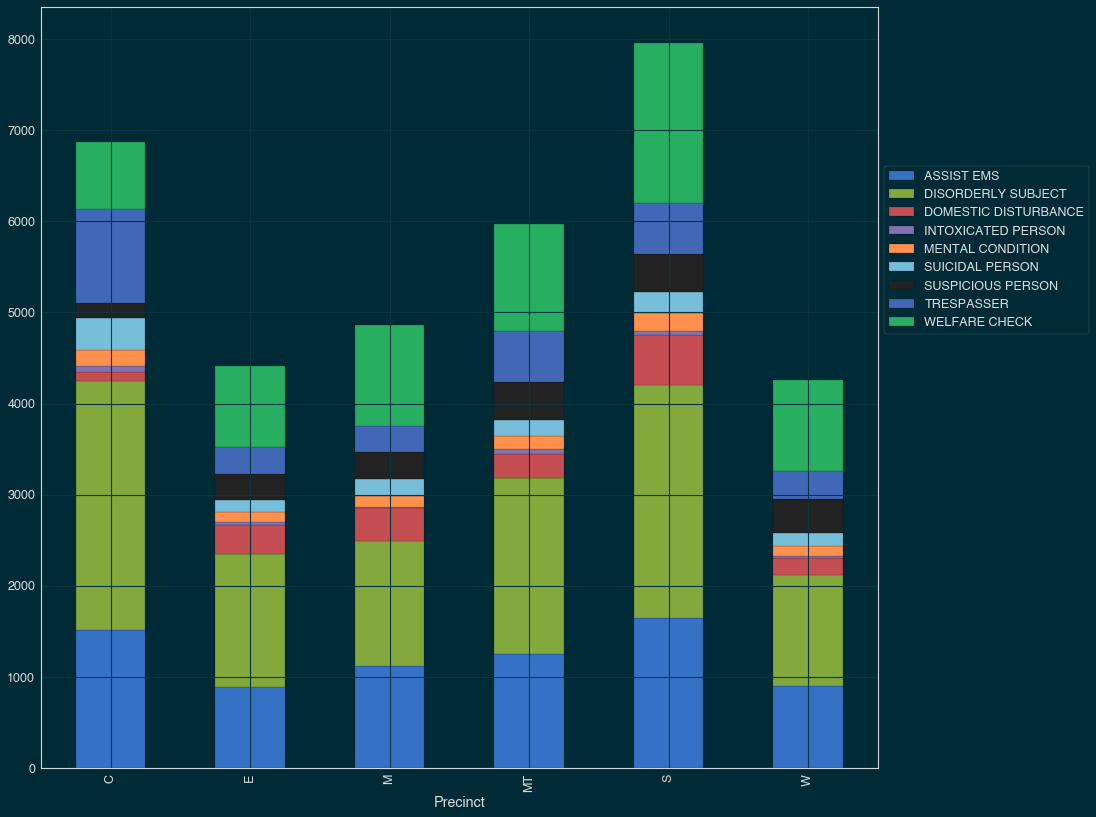

In [31]:
pd.crosstab(precinct_options['Precinct'], precinct_options['Incident Type']).plot(kind = 'bar', 
                                                          stacked = True,    
                                                          figsize=(15,14),   
                                                          edgecolor = 'black')
plt.legend(bbox_to_anchor = (1, 0.8), loc = 'upper left')

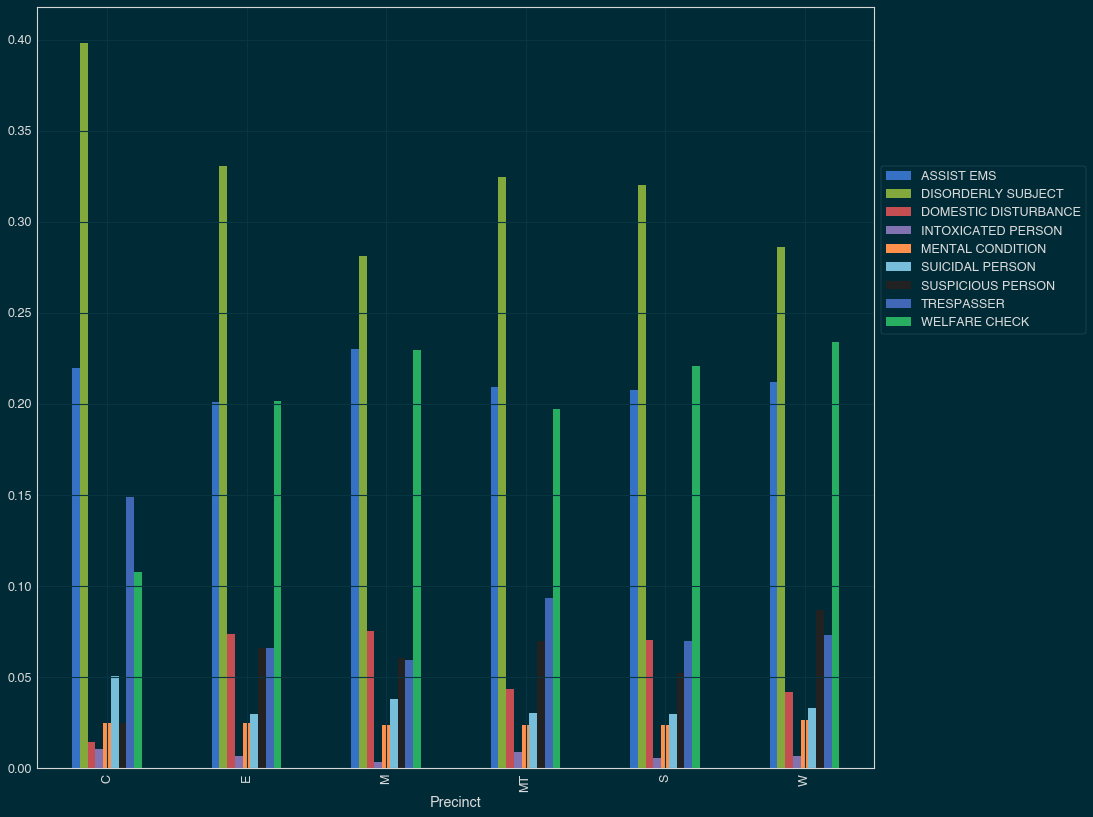

In [32]:
pd.crosstab(precinct_options['Precinct'], precinct_options['Incident Type'], normalize='index').plot(kind='bar',figsize=(15,14))

plt.legend(bbox_to_anchor = (1, 0.8), loc = 'upper left')

## proportion of incident type per precinct. Interestingly, C has larger variance between disorderly
## subject and welfare check, which is more even in every other region

In [33]:
precinct_maps = gpd.GeoDataFrame(precinct_options, geometry=gpd.points_from_xy(precinct_options.lng, precinct_options.lat))

In [34]:
precinct_maps.head(2)

,Precinct,Date,Created,Address,Incident Type,Priority,address,lat,lng,geometry
0,C,07-01-2021,01:57:16,639 LAFAYETTE ST,INTOXICATED PERSON,2,639 LAFAYETTE ST,36.152611,-86.777416,POINT (-86.77742 36.15261)
1,C,07-01-2021,03:02:52,920 BROADWAY,WELFARE CHECK,2,920 BROADWAY,36.158728,-86.784247,POINT (-86.78425 36.15873)


In [35]:
#precinct_maps.geometry.to_crs('EPSG:4326')

In [36]:
precinct_maps = precinct_maps.geometry.set_crs(epsg=4326)

davidsonco = ['36.21605012332708', '-86.7263455721062']

citymap = folium.Map(location = davidsonco, zoom_start = 11)

folium.GeoJson(precinct_maps).add_to(citymap)

for row_index, row_values in precinct_options.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['Incident Type'])
    icon=folium.Icon(color="blue", prefix='fa')
    
    marker = folium.Marker(location = loc, 
    popup = pop, icon = icon) 
    
    marker.add_to(citymap)

In [37]:
#citymap - can't run cuz of too many markers??

## Census Data

In [38]:
income.head(2)

,index,GEO_ID,NAME,tract,county,state,variable,value,description
0,0,1400000US47037010103,"Census Tract 101.03, Davidson County, Tennessee",10103,37,47,B19001_001E,990,Estimate!!Total:
1,1,1400000US47037010104,"Census Tract 101.04, Davidson County, Tennessee",10104,37,47,B19001_001E,1221,Estimate!!Total:


In [39]:
#income.variable.value_counts()

In [40]:
#education.variable.value_counts()

In [41]:
#income.shape

In [42]:
#income.GEO_ID.value_counts()

In [43]:
precinct = gpd.read_file('../data/Police Precinct District Outlines (GIS).geojson')
precinct.head(2)

,precinct,shape_area,shape_len,geometry
0,CENTRAL,98541971.0257,46234.6717307,"MULTIPOLYGON (((-86.77525 36.14894, -86.77649 ..."
1,EAST,562260180.986,90261.1338967,"MULTIPOLYGON (((-86.74977 36.24057, -86.74955 ..."


<AxesSubplot:>

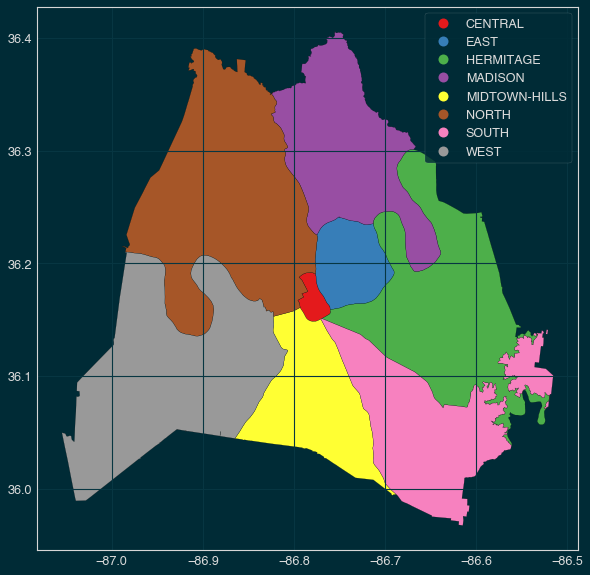

In [44]:
precinct.plot(column = 'precinct', figsize = (10,10), edgecolor = 'black', cmap = 'Set1',legend=True)

In [45]:
south_precinct = precinct.loc[precinct.precinct == 'SOUTH']

In [46]:
geocodes = gpd.read_file('../data/tl_2021_47_tract/tl_2021_47_tract.shp')

In [47]:
geocodes = geocodes.loc[geocodes.COUNTYFP == '037']

In [48]:
#ax = precinct.plot(column = 'precinct', figsize = (10,10), edgecolor = 'black', cmap = 'Set1')
#geocodes.plot(ax=ax, column = 'GEOID')

In [49]:
#geocodes.plot(column='GEOID', legend=True, figsize=(20,20))

<AxesSubplot:>

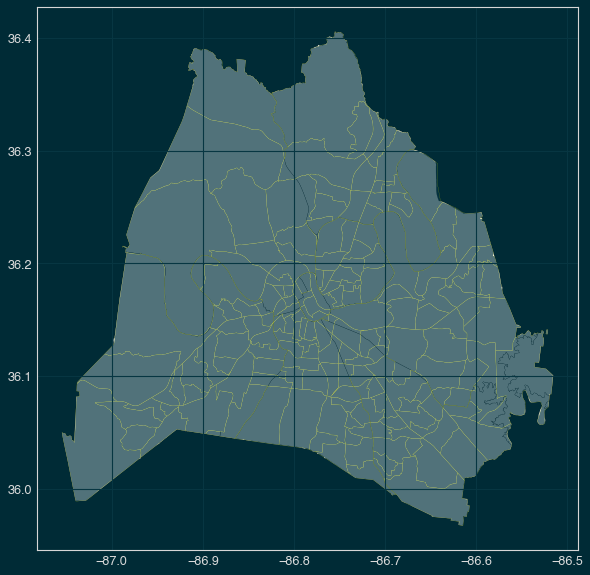

In [50]:
ax = precinct.plot(edgecolor = 'black', figsize = (10,10), color = 'white')
geocodes.plot(ax = ax, edgecolor = 'yellow', alpha = 0.7)

<AxesSubplot:>

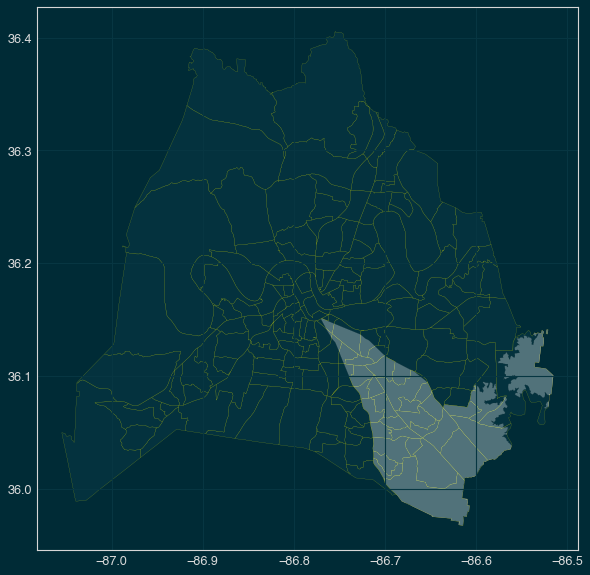

In [51]:
ax = south_precinct.plot(edgecolor = 'black', figsize = (10,10), color = 'white')
geocodes.plot(ax = ax, edgecolor = 'yellow', alpha = 0.7)

In [52]:
from shapely.geometry import Polygon

In [53]:
#geocodes.loc[geocodes.intersects(south_precinct)==True]

In [54]:
geocodes.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
37,47,037,013202,47037013202,132.02,Census Tract 132.02,G5020,S,2721406,12651,+36.1602781,-086.8703605,"POLYGON ((-86.88928 36.16390, -86.88908 36.163..."
38,47,037,013201,47037013201,132.01,Census Tract 132.01,G5020,S,1909944,254000,+36.1496854,-086.8826046,"POLYGON ((-86.89208 36.14293, -86.89191 36.143..."


In [55]:
Sgeo = gpd.sjoin(geocodes, south_precinct, op = 'within')

/var/folders/hj/gwyp74ts7pbfttf0m1t3xp1r0000gn/T/ipykernel_24052/2347970157.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  Sgeo = gpd.sjoin(geocodes, south_precinct, op = 'within')


In [56]:
#Sgeo
#Sgeo_list = Sgeo['GEOID']
#Sgeo_list

In [57]:
#Sgeo_list = ['1400000US' + i for i in Sgeo_list]

<AxesSubplot:>

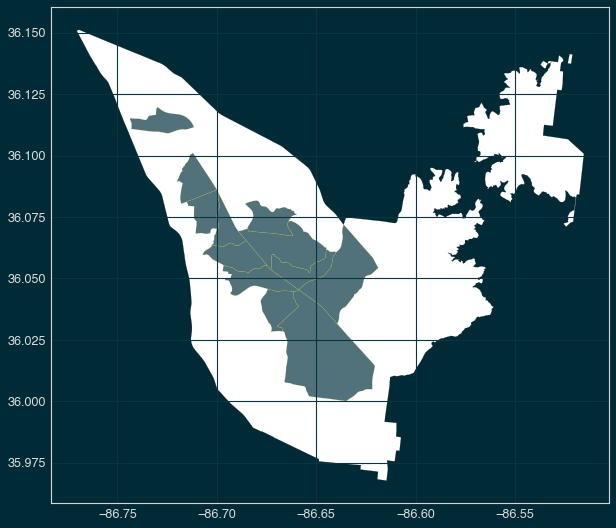

In [58]:
ax = south_precinct.plot(edgecolor = 'black', figsize = (10,10), color = 'white')
Sgeo.plot(ax = ax, edgecolor = 'yellow', alpha = 0.7)

In [59]:
#income[income['GEO_ID'].isin(Sgeo_list)]

In [60]:
geocodes.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
37,47,037,013202,47037013202,132.02,Census Tract 132.02,G5020,S,2721406,12651,+36.1602781,-086.8703605,"POLYGON ((-86.88928 36.16390, -86.88908 36.163..."
38,47,037,013201,47037013201,132.01,Census Tract 132.01,G5020,S,1909944,254000,+36.1496854,-086.8826046,"POLYGON ((-86.89208 36.14293, -86.89191 36.143..."


##### Identify Geocode centroids to determine tracts that lie in precinct:

In [61]:
geocodes['center'] = geocodes.geometry.centroid

/var/folders/hj/gwyp74ts7pbfttf0m1t3xp1r0000gn/T/ipykernel_24052/459847152.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geocodes['center'] = geocodes.geometry.centroid


In [62]:
geocodes.dtypes

STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
center      geometry
dtype: object

In [63]:
geocenters = geocodes.drop(['geometry'], axis=1)

In [64]:
geocenters = geocenters.rename(columns={'center':'geometry'})

### Income

In [65]:
## remove summary variables from income census
income = income.loc[income.variable != 'B19001_001E']

#### Precinct S Income

In [66]:
Stract = gpd.sjoin(geocenters, south_precinct, op = 'within')

/var/folders/hj/gwyp74ts7pbfttf0m1t3xp1r0000gn/T/ipykernel_24052/1323341663.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  Stract = gpd.sjoin(geocenters, south_precinct, op = 'within')


<AxesSubplot:>

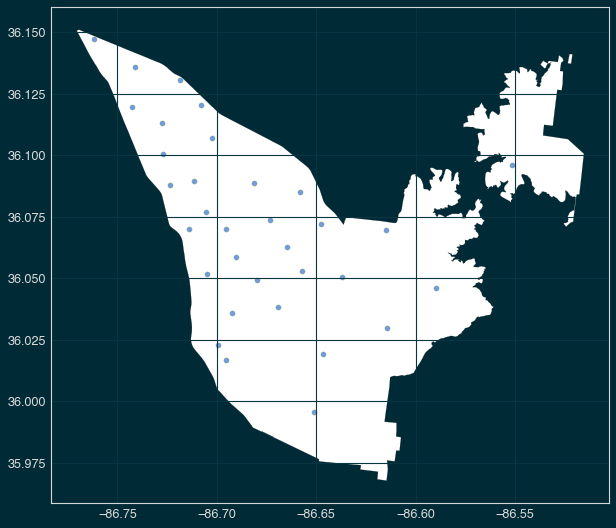

In [67]:
ax = south_precinct.plot(edgecolor = 'black', figsize = (10,10), color = 'white')
Stract.plot(ax = ax, edgecolor = 'yellow', alpha = 0.7)

In [68]:
Stract_list = Stract['GEOID']

In [69]:
Stract_list = ['1400000US' + i for i in Stract_list]

In [70]:
s_income = income[income['GEO_ID'].isin(Stract_list)]

In [71]:
s_income.groupby(['variable']).sum()

,index,tract,county,state,value
variable,,,,,
B19001_002E,6438,412097,888,1128,2129
B19001_003E,10302,412097,888,1128,1318
B19001_004E,14166,412097,888,1128,1665
B19001_005E,18030,412097,888,1128,2264
B19001_006E,21894,412097,888,1128,2642
B19001_007E,25758,412097,888,1128,2208
B19001_008E,29622,412097,888,1128,2351
B19001_009E,33486,412097,888,1128,2403
B19001_010E,37350,412097,888,1128,1989


<AxesSubplot:title={'center':'Precinct S Income'}, xlabel='variable'>

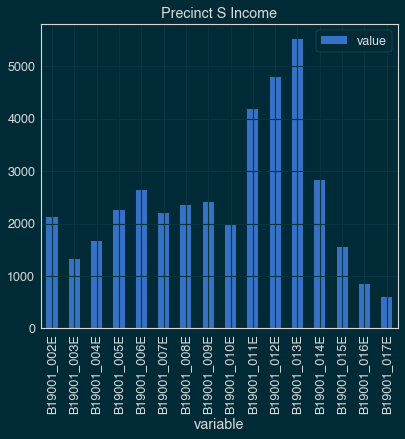

In [72]:
s_income.groupby(['variable']).sum().plot(kind='bar',
                                          y = 'value',
                                          title = 'Precinct S Income')

#### Precinct C income

In [73]:
central_precinct = precinct.loc[precinct.precinct == 'CENTRAL']

/var/folders/hj/gwyp74ts7pbfttf0m1t3xp1r0000gn/T/ipykernel_24052/2690961123.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  Ctract = gpd.sjoin(geocenters, central_precinct, op = 'within')


<AxesSubplot:>

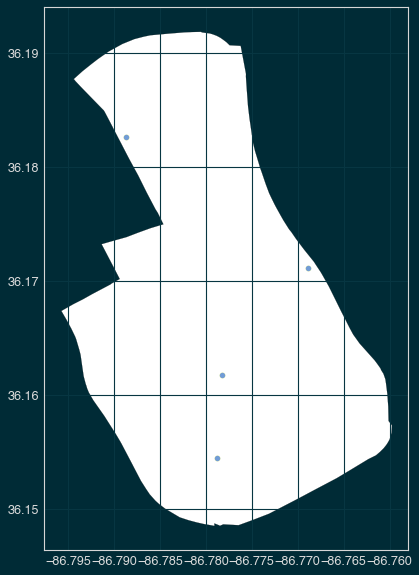

In [74]:
Ctract = gpd.sjoin(geocenters, central_precinct, op = 'within')
ax = central_precinct.plot(edgecolor = 'black', figsize = (10,10), color = 'white')
Ctract.plot(ax = ax, edgecolor = 'yellow', alpha = 0.7)

In [75]:
Ctract_list = Ctract['GEOID']
Ctract_list = ['1400000US' + i for i in Ctract_list]
c_income = income[income['GEO_ID'].isin(Ctract_list)]

<AxesSubplot:title={'center':'Precinct C Income'}, xlabel='variable'>

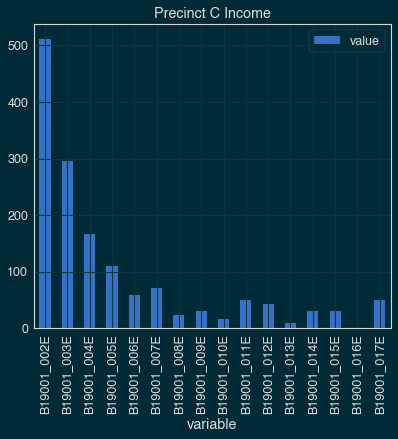

In [76]:
c_income.groupby(['variable']).sum().plot(kind='bar',
                                          y = 'value',
                                          title = 'Precinct C Income')

#### Precinct MT Income

/var/folders/hj/gwyp74ts7pbfttf0m1t3xp1r0000gn/T/ipykernel_24052/746099387.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  Mttract = gpd.sjoin(geocenters, mt_precinct, op = 'within')


<AxesSubplot:>

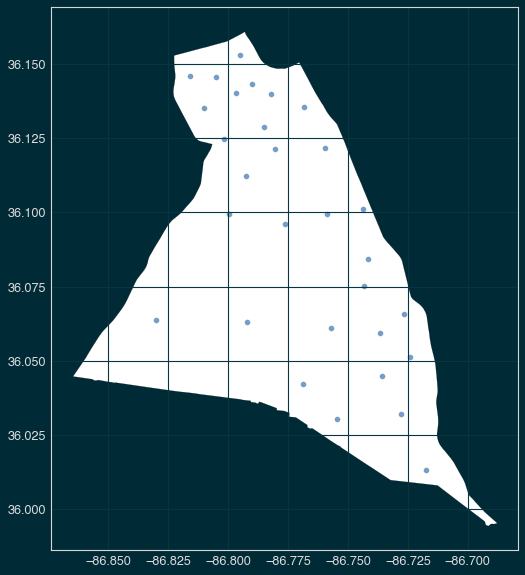

In [77]:
mt_precinct = precinct.loc[precinct.precinct == 'MIDTOWN-HILLS']
Mttract = gpd.sjoin(geocenters, mt_precinct, op = 'within')
ax = mt_precinct.plot(edgecolor = 'black', figsize = (10,10), color = 'white')
Mttract.plot(ax = ax, edgecolor = 'yellow', alpha = 0.7)

<AxesSubplot:title={'center':'Precinct MT Income'}, xlabel='variable'>

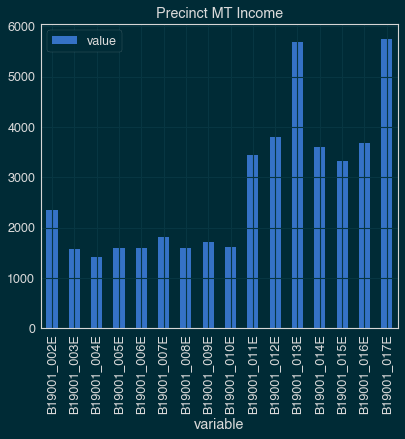

In [78]:
Mttract_list = Mttract['GEOID']
Mttract_list = ['1400000US' + i for i in Mttract_list]
Mt_income = income[income['GEO_ID'].isin(Mttract_list)]

Mt_income.groupby(['variable']).sum().plot(kind='bar',
                                          y = 'value',
                                          title = 'Precinct MT Income')

### Precinct Populations

In [79]:
## remove summary variables from age_sex census
age_sex = age_sex.loc[(age_sex.variable != 'B01001_001E') & (age_sex.variable != 'B01001_002E') & (age_sex.variable != 'B01001_026E')]

In [80]:
age_sex.head(2)

,index,GEO_ID,NAME,tract,county,state,variable,value,description
322,322,1400000US47037010103,"Census Tract 101.03, Davidson County, Tennessee",10103,37,47,B01001_003E,75,Estimate!!Total:!!Male:!!Under 5 years
323,323,1400000US47037010104,"Census Tract 101.04, Davidson County, Tennessee",10104,37,47,B01001_003E,95,Estimate!!Total:!!Male:!!Under 5 years


In [81]:
age_sex.groupby(['variable']).sum() 

,index,tract,county,state,value
variable,,,,,
B01001_003E,64722,4410248,5957,7567,23667
B01001_004E,90643,4410248,5957,7567,20098
B01001_005E,116564,4410248,5957,7567,19232
B01001_006E,142485,4410248,5957,7567,10536
B01001_007E,168406,4410248,5957,7567,8951
B01001_008E,194327,4410248,5957,7567,3732
B01001_009E,220248,4410248,5957,7567,4571
B01001_010E,246169,4410248,5957,7567,15490
B01001_011E,272090,4410248,5957,7567,34509


In [82]:
S_pop = age_sex[age_sex['GEO_ID'].isin(Stract_list)]

In [83]:
S_pop['value'].sum()

107348

In [84]:
C_pop = age_sex[age_sex['GEO_ID'].isin(Ctract_list)]

In [85]:
C_pop['value'].sum()

3428

In [86]:
## South Precinct has an estimated population of 107348, while Central Precinct only
## has est. population of 3428. Central Precinct receives a disproportionate amount
## of calls for its population size. MT Precinct has pop of 109790

In [87]:
Mt_pop = age_sex[age_sex['GEO_ID'].isin(Mttract_list)]
Mt_pop['value'].sum()

109790

In [88]:
total_pop = age_sex['value'].sum()
print(total_pop)

687488


In [89]:
total_calls = police_calls.Precinct.value_counts().sum()
police_calls.Precinct.value_counts()

H       7957
S       7953
C       6870
MT      5973
N       5515
M       4867
E       4408
W       4258
CW       118
PCW        4
CMD1       2
CMD2       1
Name: Precinct, dtype: int64

In [90]:
S_call_pct = 7953/total_calls
S_call_pct

0.16594332929933647

In [91]:
C_call_pct = 6870/total_calls
C_call_pct

0.14334599173726162

In [92]:
Mt_call_pct = 5973/total_calls
Mt_call_pct

0.12462963735759296

In [93]:
S_pop_pct = 107348/total_pop
C_pop_pct = 3428/total_pop
Mt_pop_pct = 109790/total_pop
print(S_pop_pct)
print(C_pop_pct)
print(Mt_pop_pct)

0.15614527089927388
0.004986268851238131
0.1596973328989015


In [94]:
## South Precinct accounts for %15.6 of population and %16.6 of calls.
## Central Precinct accounts for %0.5 of population and %14.3 of calls.
## Midtown-Hills Precincts accounts for %16 of populations and %12.5 of calls.

### Race and Ethnicity Demographics

In [95]:
#remove summary variables from race census
race = race.loc[(race.variable != 'B03002_001E') & (race.variable != 'B03002_002E') & (race.variable != 'B03002_012E')]

In [96]:
race.head(2)

,index,GEO_ID,NAME,tract,county,state,variable,value,description
322,322,1400000US47037010103,"Census Tract 101.03, Davidson County, Tennessee",10103,37,47,B03002_003E,2441,Estimate!!Total:!!Not Hispanic or Latino:!!Whi...
323,323,1400000US47037010104,"Census Tract 101.04, Davidson County, Tennessee",10104,37,47,B03002_003E,2713,Estimate!!Total:!!Not Hispanic or Latino:!!Whi...


In [97]:
S_race = race[race['GEO_ID'].isin(Stract_list)]
C_race = race[race['GEO_ID'].isin(Ctract_list)]
Mt_race = race[race['GEO_ID'].isin(Mttract_list)]

In [98]:
S_race.groupby(['variable']).sum()

,index,tract,county,state,value
variable,,,,,
B03002_003E,10302,412097,888,1128,41392
B03002_004E,14166,412097,888,1128,32255
B03002_005E,18030,412097,888,1128,140
B03002_006E,21894,412097,888,1128,5926
B03002_007E,25758,412097,888,1128,58
B03002_008E,29622,412097,888,1128,455
B03002_009E,33486,412097,888,1128,2754
B03002_010E,37350,412097,888,1128,257
B03002_011E,41214,412097,888,1128,2497


In [99]:
S_minority = S_race.loc[S_race.variable != 'B03002_003E']
S_minority_pct = S_minority.value.sum()/S_race.value.sum()
print(S_minority_pct)

0.6255473131897955


In [100]:
C_minority = C_race.loc[C_race.variable != 'B03002_003E']
C_minority_pct = C_minority.value.sum()/C_race.value.sum()
print(C_minority_pct)

0.8320290665176076


In [101]:
Mt_minority = Mt_race.loc[Mt_race.variable != 'B03002_003E']
Mt_minority_pct = Mt_minority.value.sum()/Mt_race.value.sum()
print(Mt_minority_pct)

0.2966801662581264


In [102]:
## South Precinct is %62.6 non-white
## Central Precinct is %83.2 non-white (and overwhelmingly African-American)
## Midtown-Hills Precinct is %29.7 non-white

In [103]:
#Precinct Stats Dictionary
#Precinct_Dict = {'Precinct' : ['South','Central','Midtown-Hills'], 
#                 'Percent_of_pop' : [0.156, 0.005, 0.159],
#                 'Percent_non_white' : [0.625, 0.832, 0.297],
#                 'Percent_calls' : [0.166, 0.143, 0.125]}
